# Autoencoder for MIDI

run tensorboard with `tensorboard --logdir=runs`

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import pad, silu
from torch.utils.tensorboard.writer import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split

from torchinfo import summary

import random
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

## Notebook Setup

### Dark Mode

In [2]:
plt.style.use("dark_background")

In [3]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

### Constants / Parameters

In [4]:
# constants
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NOISE_FACTOR = 0.0

Move to GPU if available

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Load Data

### Custom Dataset

In [6]:
class MIDILoopDataset(Dataset):
    def __init__(
        self,
        data,
        multiplier=1,
        transforms=None,
    ):
        self.data = data * multiplier
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name, image = self.data[idx]
        image = self.format_image(image)
        if self.transforms:
            image = self.transforms(image)
        return name, image

    def format_image(self, image, remove_time=True):
        if remove_time:
            image = np.delete(image, 0, axis=1)
        image = torch.from_numpy(np.expand_dims(image, 0)).to(torch.float32)
        if torch.any(image > 1.0):
            image = image / image.max()
        image = pad(input=image, pad=(0, 12, 1, 1), mode="constant", value=0.0)

        return image

### Augmentation Functions

In [7]:
def shift_image_vertically(name, array, num_iterations):
    shifted_images = []

    def find_non_zero_bounds(arr):
        # Find the first and last row index with a non-zero element
        rows_with_non_zero = np.where(arr.any(axis=1))[0]
        if len(rows_with_non_zero) == 0:
            return (0, arr.shape[0] - 1)  # Handle case with no non-zero elements
        return rows_with_non_zero[0], rows_with_non_zero[-1]

    def shift_array(arr, up=0, down=0):
        # Shift array vertically
        if up > 0:
            arr = np.roll(arr, -up, axis=0)
            arr[-up:] = 0
        elif down > 0:
            arr = np.roll(arr, down, axis=0)
            arr[:down] = 0
        return arr

    highest, lowest = find_non_zero_bounds(array)
    maximum_up = highest
    maximum_down = array.shape[0] - lowest - 1

    for _ in range(num_iterations):
        # Shift up and then down, decreasing the shift amount in each iteration
        for i in range(maximum_up, 0, -1):
            new_key = f"{Path(name).stem}_u{i:02d}"
            shifted_images.append((new_key, np.copy(shift_array(array, up=i))))
        for i in range(maximum_down, 0, -1):
            new_key = f"{Path(name).stem}_d{i:02d}"
            shifted_images.append((new_key, np.copy(shift_array(array, down=i))))

    random.shuffle(shifted_images)

    return shifted_images[:num_iterations]

In [8]:
# def augment_data(clean_images, num_permutations=NUM_PERMUTATIONS, vshift=True):
#     """Augments a set of passed-in images by a factor of 2*num_permutations"""
#     shifted_images = []
#     noisy_images = []

#     for name, image in tqdm(
#         list(clean_images.items()), unit="images", dynamic_ncols=True
#     ):
#         time_factor = image[:, 0]  # save time factor
#         image = np.delete(image, 0, axis=1)  # remove it from the image though
#         if vshift:
#             # vertical shift images
#             shifted_images.append(shift_image_vertically(name, image, num_permutations))
#         else:
#             # reformat clean image array
#             shifted_images.append([(name, image)])

#         # add noise to images
#         for si in shifted_images[-1]:
#             new_key, shifted_image = si
#             for _ in range(num_permutations):
#                 # normalize
#                 noisy_image = shifted_image / np.max(shifted_image)

#                 # corrupt
#                 noisy_image = torch.from_numpy(
#                     noisy_image
#                 ) + NOISE_FACTOR * torch.randn(noisy_image.shape)

#                 # reformat
#                 noisy_image = format_image(noisy_image)

#                 noisy_images.append((new_key, noisy_image))

#     random.shuffle(noisy_images)

#     return shifted_images, noisy_images

### Build Datasets

In [9]:
input_dataset = np.load("data/all_loops.npz")
inputset = MIDILoopDataset(list(input_dataset.items()))
overfitset = MIDILoopDataset([list(input_dataset.items())[0]], multiplier=3200)
trainset, testset = random_split(inputset, [0.8, 0.2])

trainLoader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
testLoader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
overfitLoader = DataLoader(
    overfitset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

In [10]:
for batch in overfitLoader:
    batch1 = batch
    break

print(batch1[1].shape)

torch.Size([32, 1, 60, 412])


## Utility Functions

In [11]:
def plot_images(images, titles, set_axis="off"):
    num_images = len(images)
    for num_plot in range(num_images):
        plt.subplot(num_images, 1, num_plot + 1)
        plt.imshow(
            np.squeeze(images[num_plot]),
            aspect="auto",
            origin="lower",
            cmap="magma",
            interpolation="nearest",
        )
        plt.title(titles[num_plot])
        plt.axis(set_axis)

    plt.show()

## Autoencoder Setup

### Model

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.pool(silu(self.enc1(x)))
        x = self.pool(silu(self.enc2(x)))
        x = self.pool(silu(self.enc3(x)))
        x = self.pool(silu(self.enc4(x)))

        # Decoder
        x = silu(self.dec1(x))
        x = silu(self.dec2(x))
        x = silu(self.dec3(x))
        x = silu(self.dec4(x))
        # x = torch.sigmoid(self.out(x))
        x = silu(self.out(x))

        return x


model = AutoEncoder().to(device)

In [13]:
print(model)

AutoEncoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [14]:
print(summary(model, (1, 58, 400)))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 60, 412]              --
├─Conv2d: 1-1                            [64, 58, 400]             640
├─MaxPool2d: 1-2                         [64, 29, 200]             --
├─Conv2d: 1-3                            [32, 29, 200]             18,464
├─MaxPool2d: 1-4                         [32, 14, 100]             --
├─Conv2d: 1-5                            [16, 14, 100]             4,624
├─MaxPool2d: 1-6                         [16, 7, 50]               --
├─Conv2d: 1-7                            [8, 7, 50]                1,160
├─MaxPool2d: 1-8                         [8, 3, 25]                --
├─ConvTranspose2d: 1-9                   [8, 7, 51]                584
├─ConvTranspose2d: 1-10                  [16, 15, 103]             1,168
├─ConvTranspose2d: 1-11                  [32, 30, 206]             2,080
├─ConvTranspose2d: 1-12                  [64, 60, 412]             

### Optimizer and Loss Functions

In [15]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train and Test Functions

In [16]:
def train(net, trainLoader, num_epochs=NUM_EPOCHS, logging=True):
    train_loss = []
    if logging:
        writer = SummaryWriter(
            f"runs/{datetime.now().strftime('%y-%m-%d_%H%M%S')}_reset"
        )
    for epoch in trange(num_epochs):
        running_loss = 0.0
        with tqdm(trainLoader, unit="batch") as tepoch:
            for i, data in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1:02d}")
                name, img = data
                # add noise to the image data
                img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
                # clip to make the values fall between 0 and 1
                img_noisy = np.clip(img_noisy, 0.0, 1.0)
                img_noisy = img_noisy.to(device)
                optimizer.zero_grad()
                outputs = net(img_noisy)

                loss = loss_fn(outputs, img_noisy)
                # backpropagation
                loss.backward()
                # update the parameters
                optimizer.step()
                running_loss += loss.item()
                tepoch.set_postfix(loss=f"{loss.item():03f}")

                if logging:
                    global_step = epoch * len(trainLoader) + i
                    writer.add_scalar("training/loss", loss.item(), global_step)
                    for p_name, param in model.named_parameters():
                        writer.add_histogram(
                            f"weights/{p_name}", param.data, global_step
                        )
                        if param.requires_grad:
                            writer.add_histogram(
                                f"gradients/{p_name}.grad", param.grad, global_step
                            )

            loss = running_loss / len(trainLoader)
            train_loss.append(loss)

    return train_loss

In [17]:
def test_image_reconstruction(net, loader, loss):
    for batch in loader:
        name, img = batch

        img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
        img_noisy = np.clip(img_noisy, 0.0, 1.0)
        img_noisy = img_noisy.to(device)

        outputs = net(img_noisy)

        images = [
            inputset.format_image(input_dataset[name[0]]),
            img_noisy[0].cpu().data,
            outputs[0].cpu().data,
        ]
        titles = [
            f"{name[0]} (epochs={NUM_EPOCHS})",
            f"noisy ({NOISE_FACTOR}% noise)",
            f"reconstructed (loss={loss[-1]:.03f})",
        ]

        plot_images(images, titles)
        break

## Model Training

In [18]:
# train_loss = train(model, trainLoader, NUM_EPOCHS)
train_loss = train(model, overfitLoader, NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?batch/s]

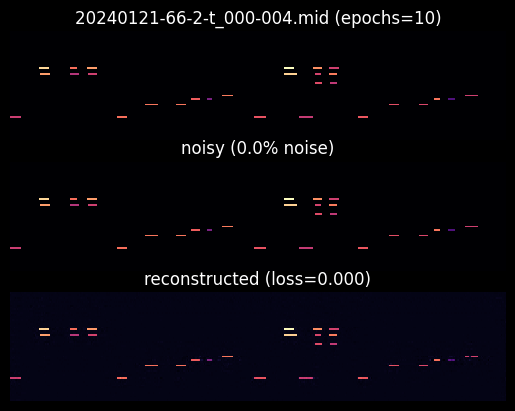

In [ ]:
test_image_reconstruction(model, overfitLoader, train_loss)

###